## Inject Bugs & Run Experiment

![Inject Bugs & Run Experiment](./pic/RL_Testing.drawio.png)

#### Frozenlake Testbed Experiment

- Find log files in RLTestig/logs/frozenlake

In [43]:
import frozenlake.testing_SB3_Frozenlake as Frozenlake_Experiment

# initialize bug_version_list
bug_version_list = [
    # [],
    [0],
    [1],
    [2],
    [3],
    [4],
    # [6],
    # [7],
    # [8],
    # [9],
    # [10],
]

Frozenlake_Experiment.main(bug_version_list=bug_version_list, rounds=25, epochs=300, model_type='dqn')


import warnings
from typing import Any, ClassVar, Dict, List, Optional, Tuple, Type, TypeVar, Union

import numpy as np
import torch as th
from gymnasium import spaces
from torch.nn import functional as F

from stable_baselines3.common.buffers import ReplayBuffer
from stable_baselines3.common.off_policy_algorithm import OffPolicyAlgorithm
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import get_linear_fn, get_parameters_by_name, polyak_update
from stable_baselines3.dqn.policies import CnnPolicy, DQNPolicy, MlpPolicy, MultiInputPolicy, QNetwork

SelfDQN = TypeVar("SelfDQN", bound="DQN")


class DQN(OffPolicyAlgorithm):
    """
    Deep Q-Network (DQN)

    Paper: https://arxiv.org/abs/1312.5602, https://www.nature.com/articles/nature14236
    Default hyperparameters are taken from the Nature paper,
    except for the optimizer and learning rate that were taken

#### Mountaincar Testbed (continous) Experiment

- Find log files in RLTestig/logs/mountaincar

In [ ]:
import mountaincar.testing_SB3_Mountaincar as Mountaincar_Experiment

bug_version_list = [
    [],
    # [5],
    # [6],
    # [7],
    # [8],
    # [10],
    # [11],
    # [12],
    # [13],
    # [14],
    # [15]
]

Mountaincar_Experiment.main(bug_version_list=bug_version_list, rounds=10, epochs=300, model_type='ppo')


## Validation Part

In [2]:
import log_parser
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import config_parser
from scipy.stats import binomtest


root_dir = config_parser.parserConfig()['root_dir']


def linelar_regression(data, title = 'Data Trend Analysis', show=False):

    # 将数据转换成Pandas Series对象
    series = pd.Series(data)

    # 计算简单移动平均(SMA)和指数移动平均(EMA)
    sma = series.rolling(window=3).mean()
    ema = series.ewm(span=3, adjust=False).mean()

    # 使用线性回归判断趋势
    slope, intercept, r_value, p_value, std_err = linregress(range(len(data)), data)
    
    if show:
        # 绘制数据和趋势线
        plt.figure(figsize=(12, 6))
        plt.plot(data, label='Original Data', marker='o')
        plt.plot(range(len(data)), intercept + slope * np.asarray(range(len(data))), 'r', label=f'Trend Line: slope={slope:.2f}')
        plt.legend()
        plt.title(title)
        plt.show()

    # 输出线性回归结果
    # print(f"Slope of trend line: {slope:.2f}")

    # 如果斜率显著小于0，我们可以认为不存在上升趋势
    if slope < 0:
        return 'false'
    else:
        return 'true'
    

def test_true_proportion(num_samples, num_true, sig_level=0.05, expected_prob=0.95):
    """
    对观察到的 'true' 样本数进行二项检验。

    :param num_samples: 样本总数
    :param num_true: 观察到的 'true' 样本数
    :param sig_level: 显著性水平（默认为 0.05）
    :param expected_prob: 预期成功概率（默认为 0.5）
    :return: p 值和是否显著
    """
    # 计算二项检验的 p 值
    p_value = binomtest(k=num_true, n=num_samples, p=expected_prob, alternative='greater')

    # 判断是否显著
    is_significant = p_value < sig_level

    return p_value, is_significant


def bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[]')), show_fig=False):
    # 使用 Path.rglob() 获取所有子文件
    # '**/*' 表示匹配所有的文件和文件夹, 如果只想匹配文件, 使用 '**/*.*'
    bug_free_log_list = [file for file in bug_free_log_path.rglob('*') if file.is_file()]
    print(bug_free_log_list)

    result = []
    for path in bug_free_log_list:
        # print(log_parser.parse_log_file(path))
        data = log_parser.parse_log_file_fuzzy(path)
        if len(data)> 0:
            temp = linelar_regression(data, title=path, show=show_fig)
        result.append(temp)

    p_value = binomtest(result.count('true'), len(result), alternative='greater')
    print(p_value)

    
    
def bin_test_mountaincar(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Mountaincar', 'sac', '[]')), show_fig=False):
    # 使用 Path.rglob() 获取所有子文件
    # '**/*' 表示匹配所有的文件和文件夹, 如果只想匹配文件, 使用 '**/*.*'
    bug_free_log_list = [file for file in bug_free_log_path.rglob('*') if file.is_file()]

    print(bug_free_log_list)

    # accuracy_list = []
    # 打印所有文件路径
    result = []
    for path in bug_free_log_list:
        data = log_parser.parse_mountaincar_log_file(path)
        if len(data) > 0:
            temp = linelar_regression(data, title=path, show=show_fig)
        result.append(temp)
    
    
    '''
    在进行二项检验时，零假设（null hypothesis）通常是观察到的成功次数与随机变化相一致，即成功的概率等于 expected_prob。如果实际观察到的成功次数显著高于（或低于）这个期望成功概率，那么您可能会得到一个很小的 p 值，从而拒绝零假设。
    '''
    p_value = binomtest(result.count('true'), len(result), alternative='greater')
    print(p_value)



/var/folders/37/mwcx5pmx1k7c6s8w_rj88r080000gq/T/ipykernel_23196/908381423.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


[PosixPath('/Users/zhangshiyu/Documents/GitHub/stable-baselines3-testing-new/RLTesting/logs/Frozenlake/dqn/[3]/time_2024-03-01[3]round_8'), PosixPath('/Users/zhangshiyu/Documents/GitHub/stable-baselines3-testing-new/RLTesting/logs/Frozenlake/dqn/[3]/time_2024-03-01[3]round_15'), PosixPath('/Users/zhangshiyu/Documents/GitHub/stable-baselines3-testing-new/RLTesting/logs/Frozenlake/dqn/[3]/time_2024-03-01[3]round_12'), PosixPath('/Users/zhangshiyu/Documents/GitHub/stable-baselines3-testing-new/RLTesting/logs/Frozenlake/dqn/[3]/time_2024-03-01[3]round_6'), PosixPath('/Users/zhangshiyu/Documents/GitHub/stable-baselines3-testing-new/RLTesting/logs/Frozenlake/dqn/[3]/time_2024-03-01[3]round_24'), PosixPath('/Users/zhangshiyu/Documents/GitHub/stable-baselines3-testing-new/RLTesting/logs/Frozenlake/dqn/[3]/time_2024-03-01[3]round_23'), PosixPath('/Users/zhangshiyu/Documents/GitHub/stable-baselines3-testing-new/RLTesting/logs/Frozenlake/dqn/[3]/time_2024-03-01[3]round_1'), PosixPath('/Users/zhan

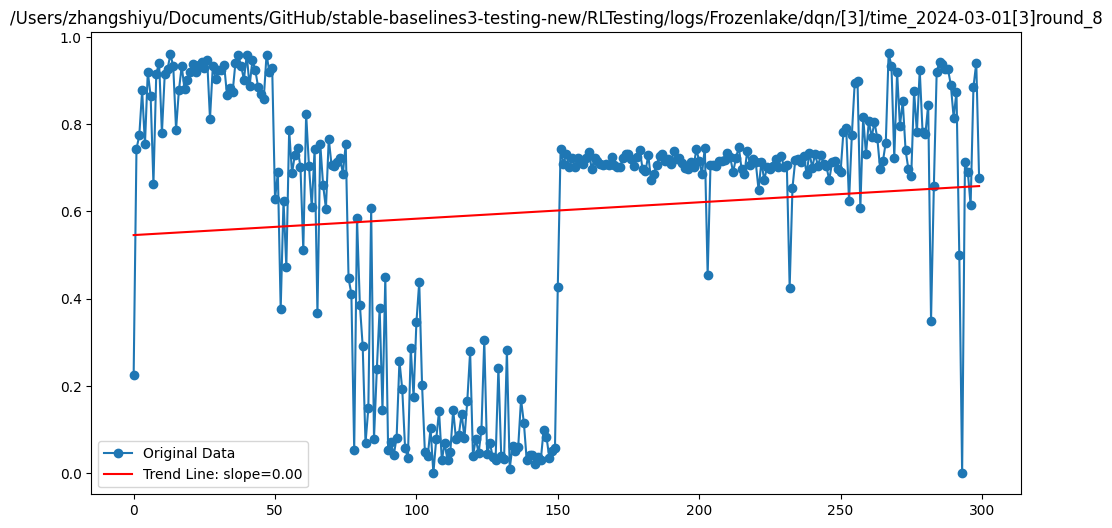

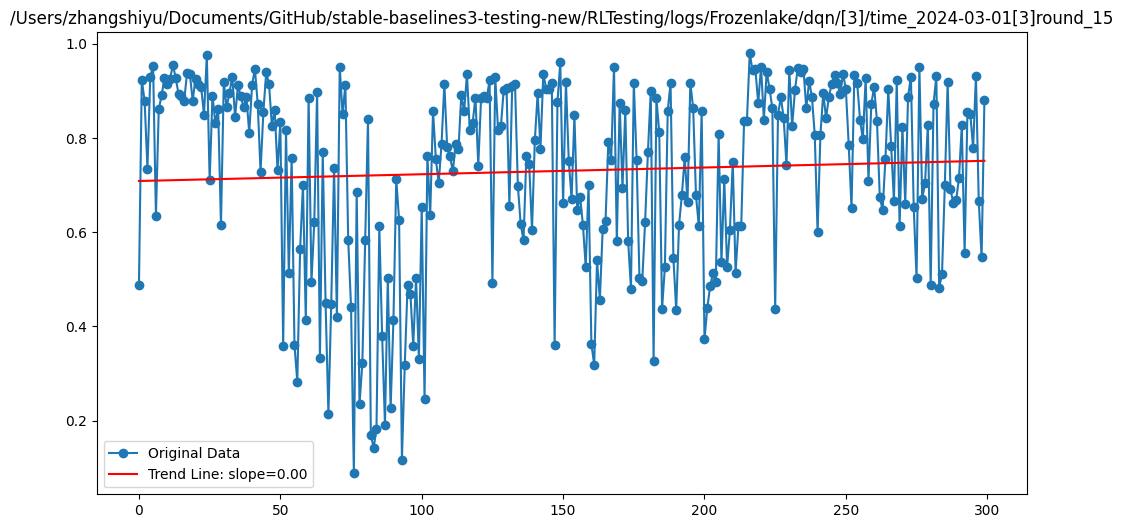

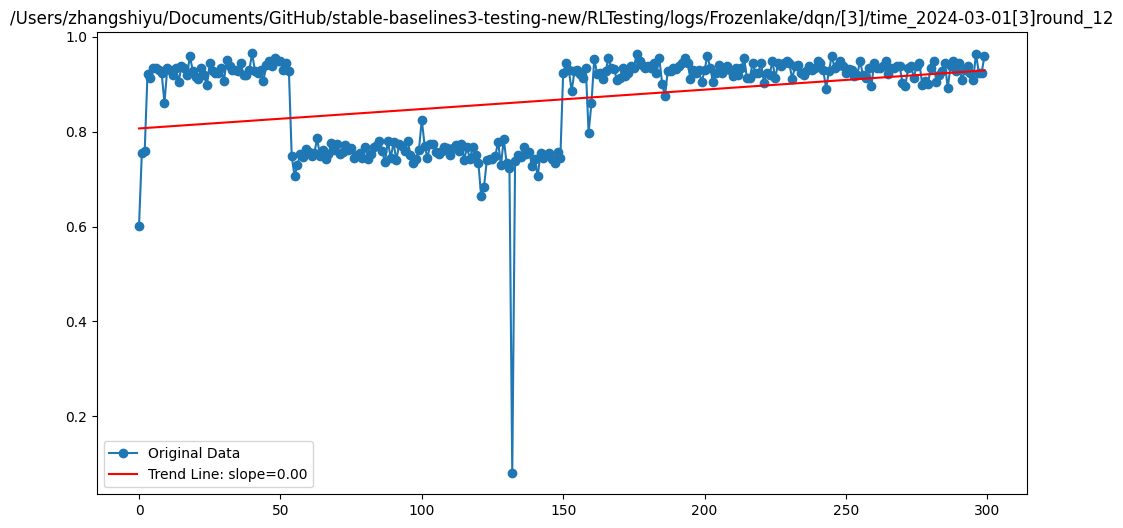

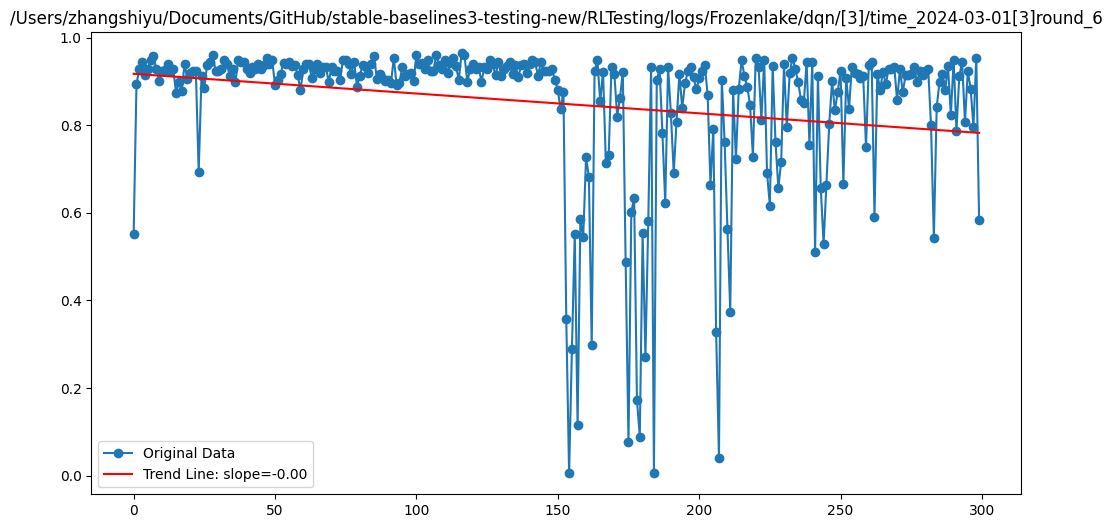

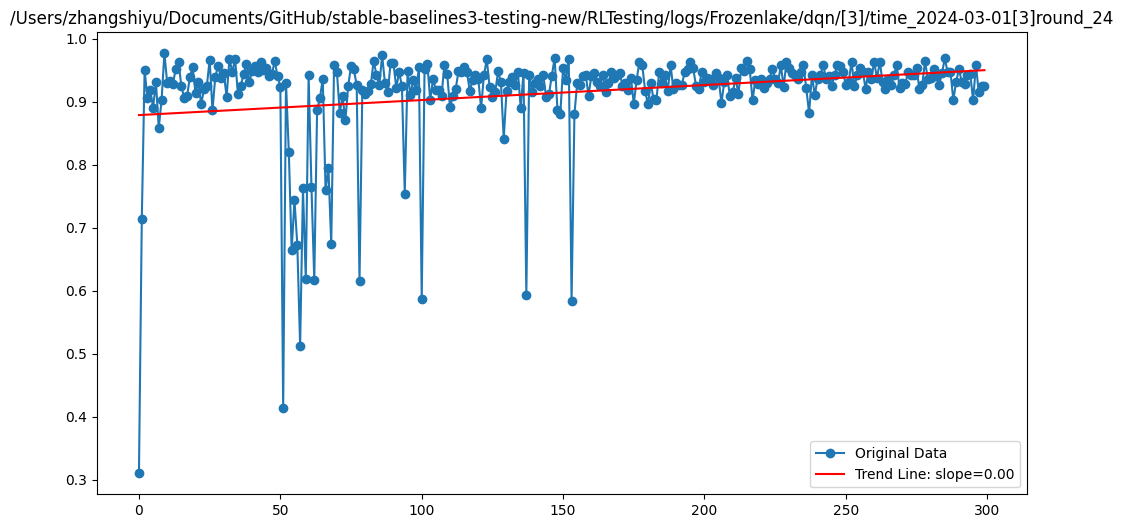

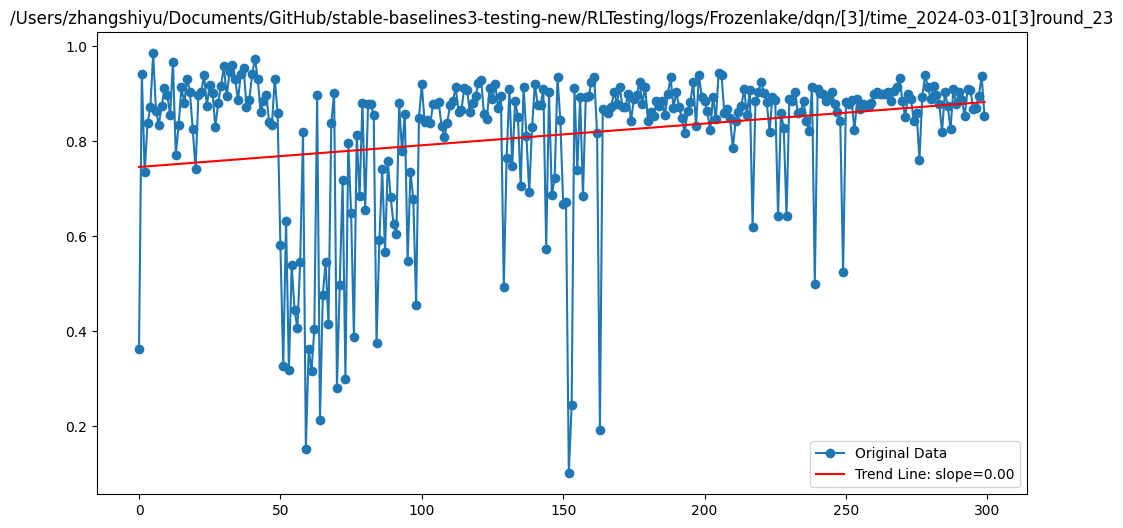

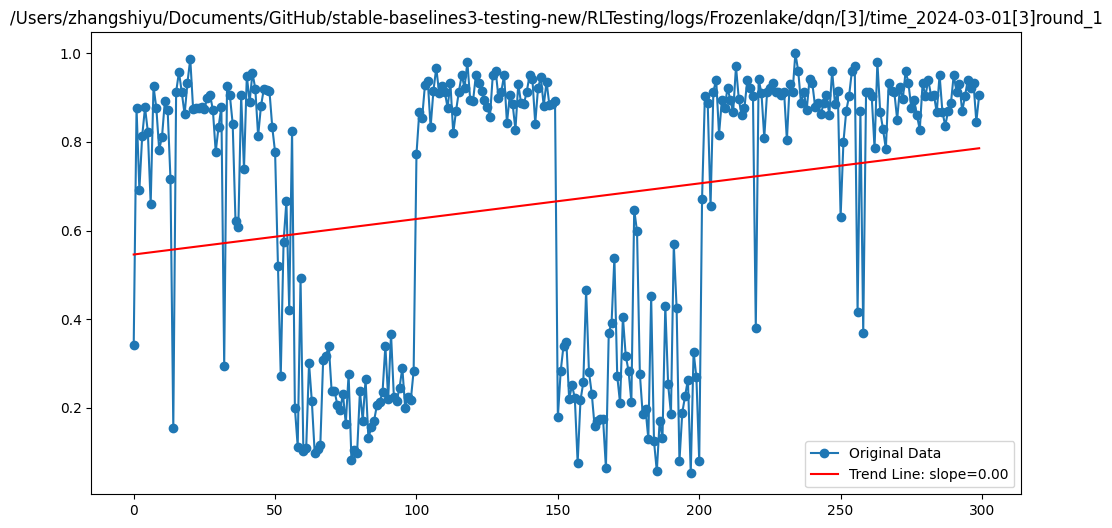

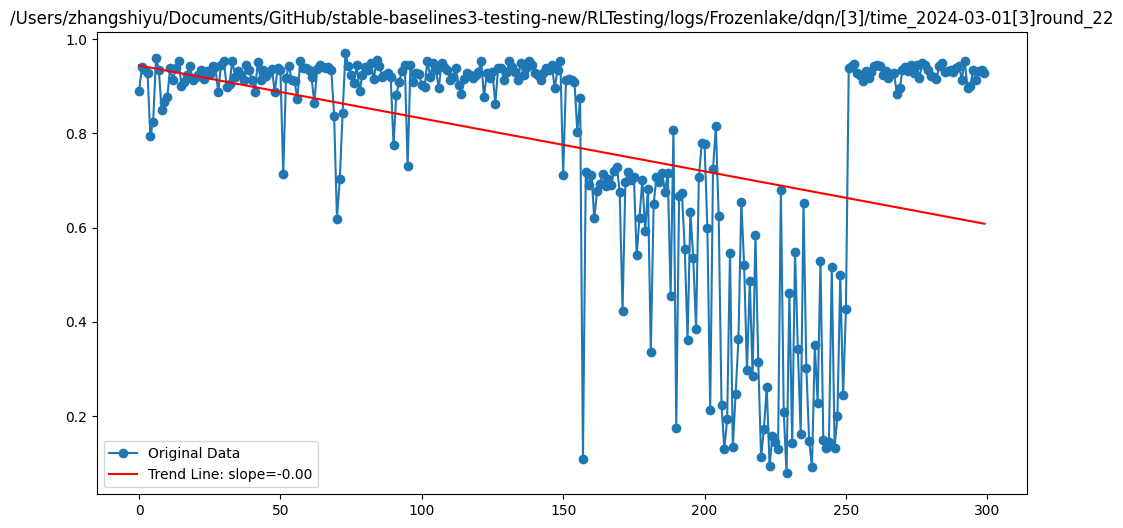

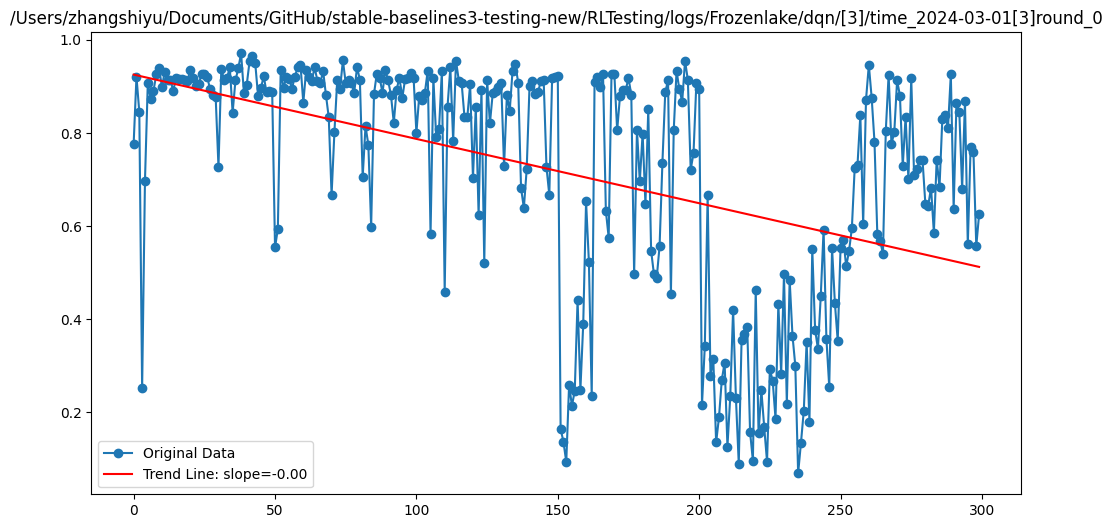

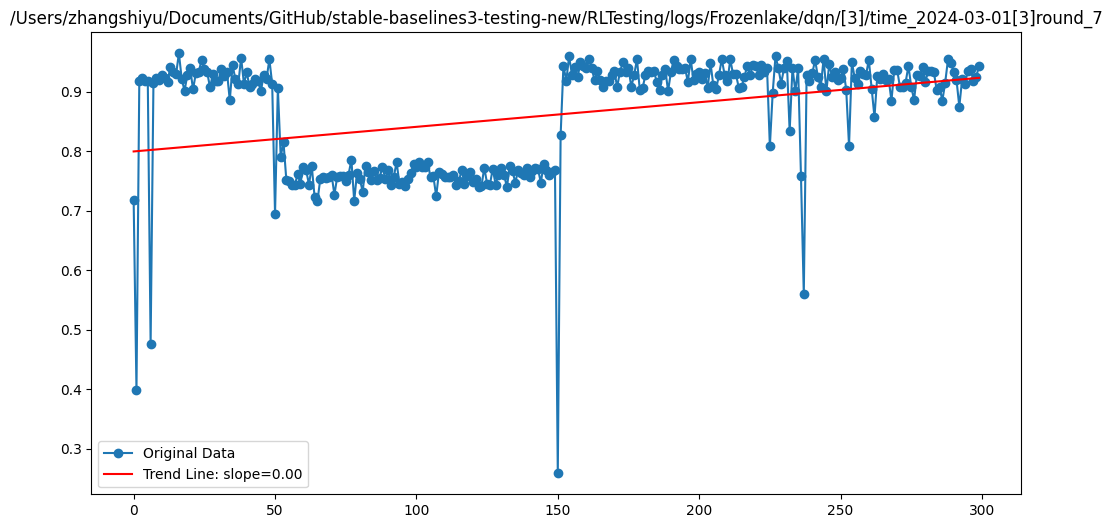

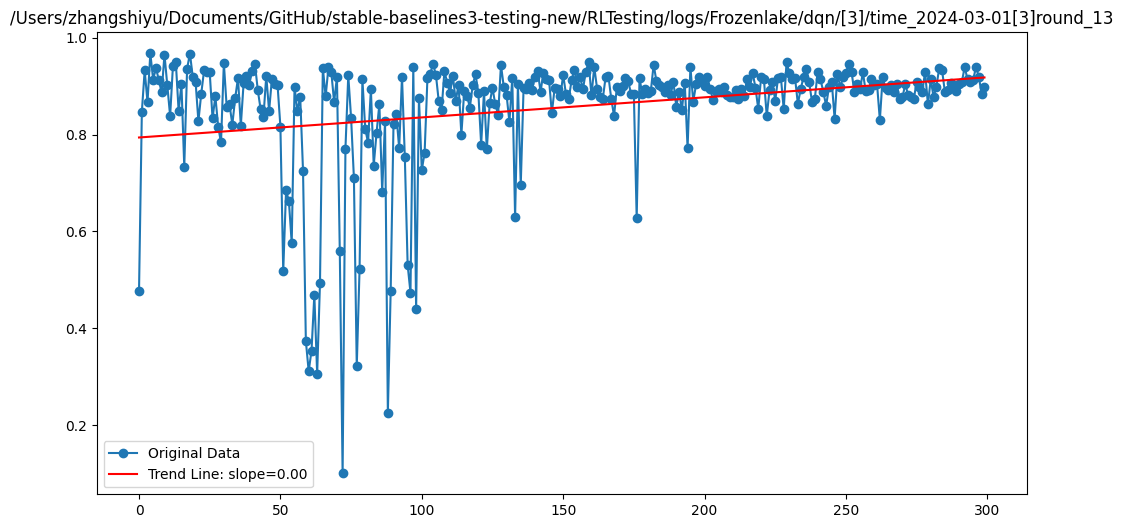

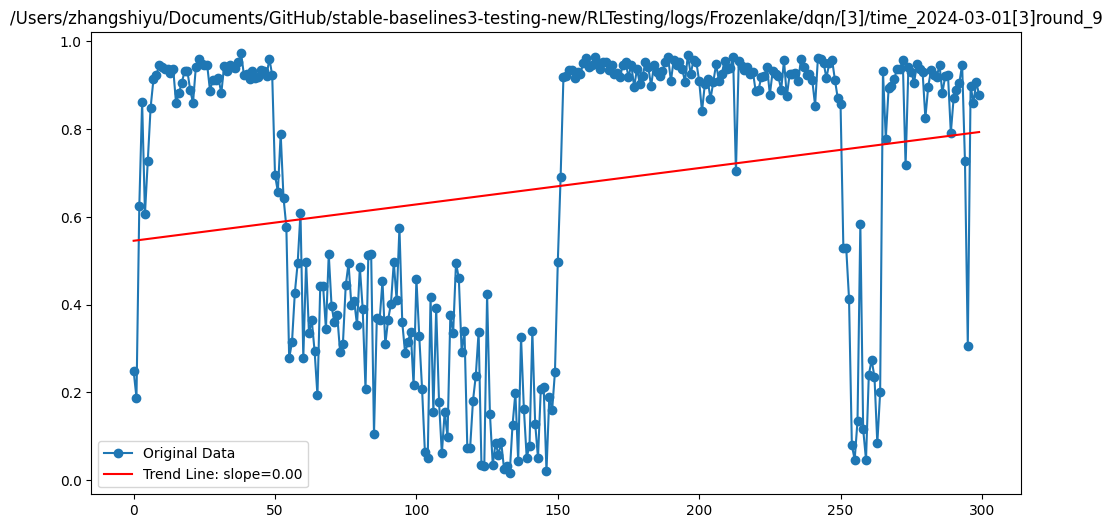

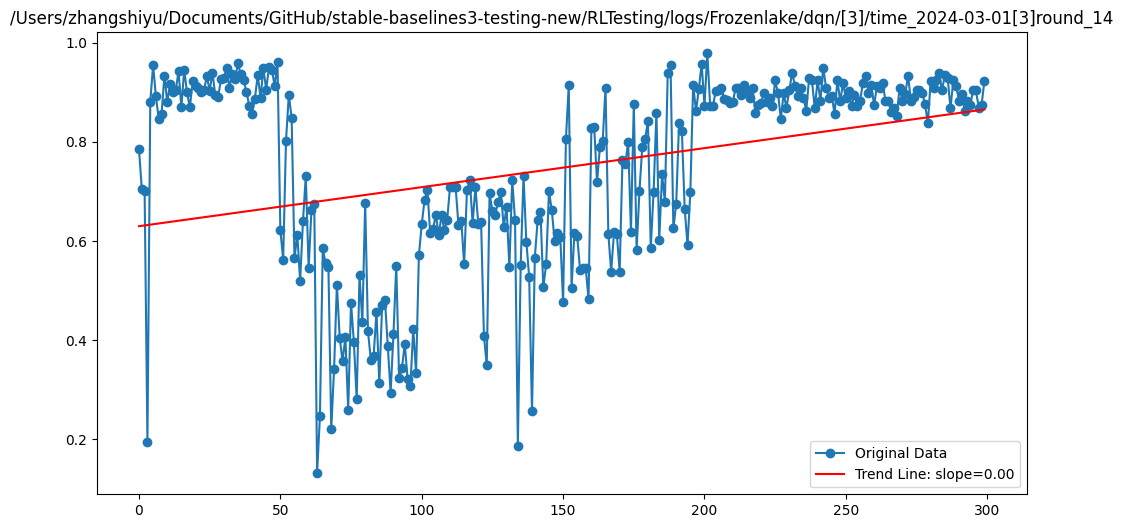

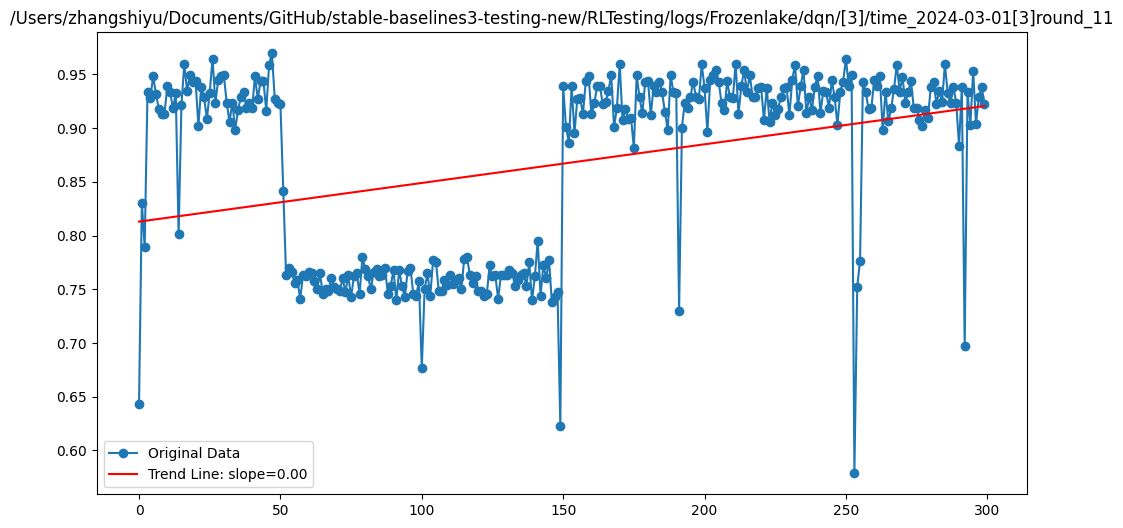

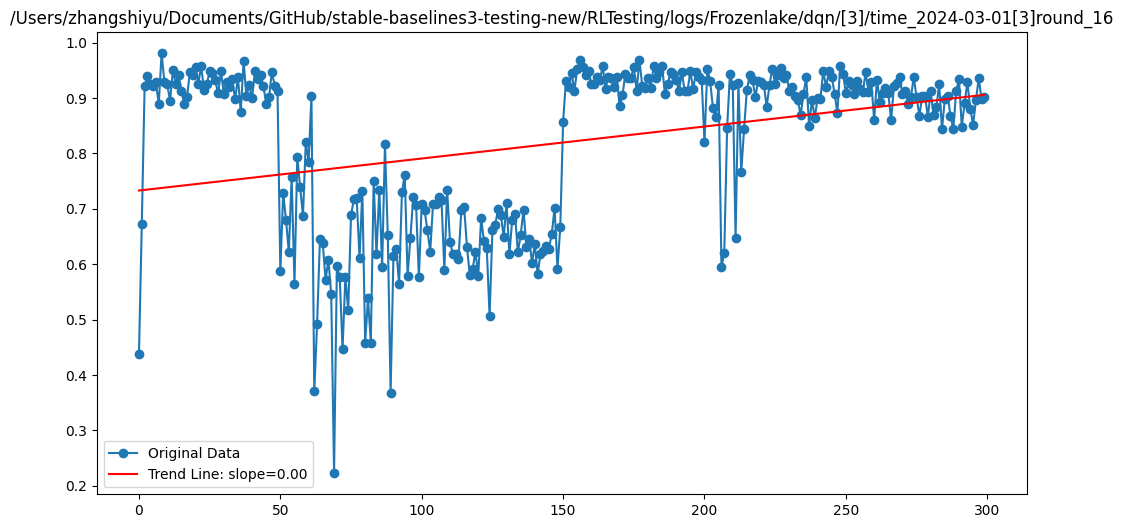

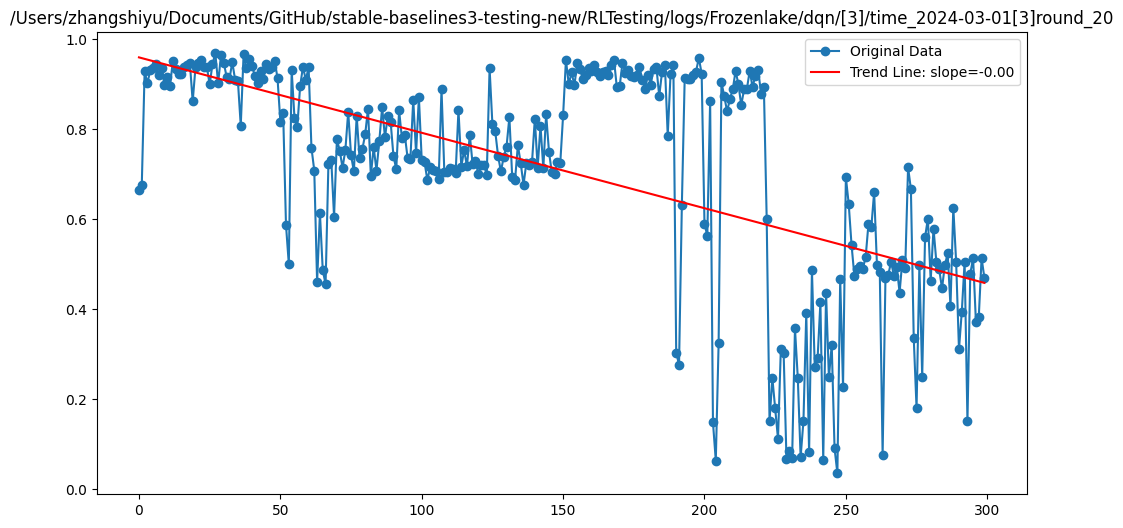

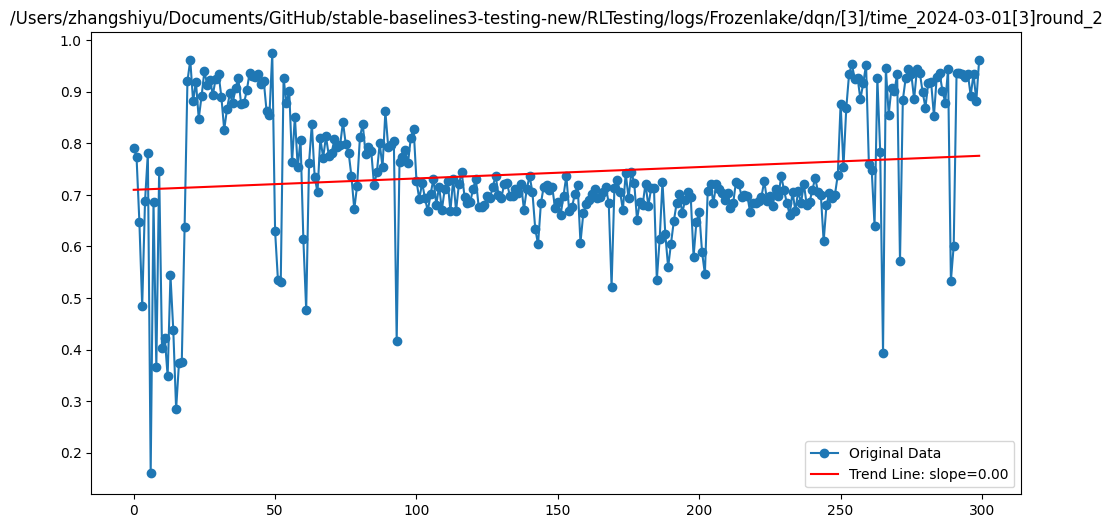

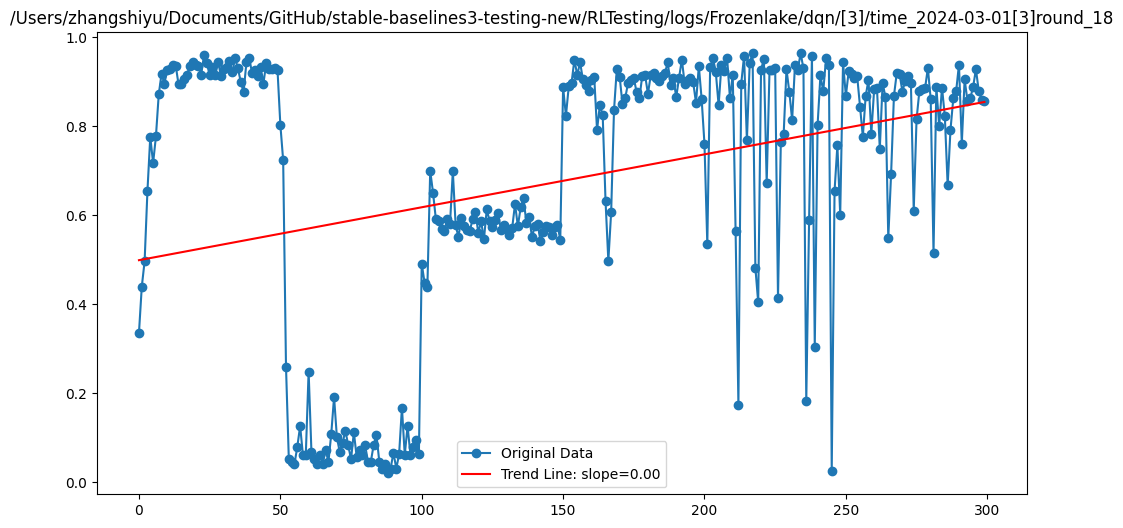

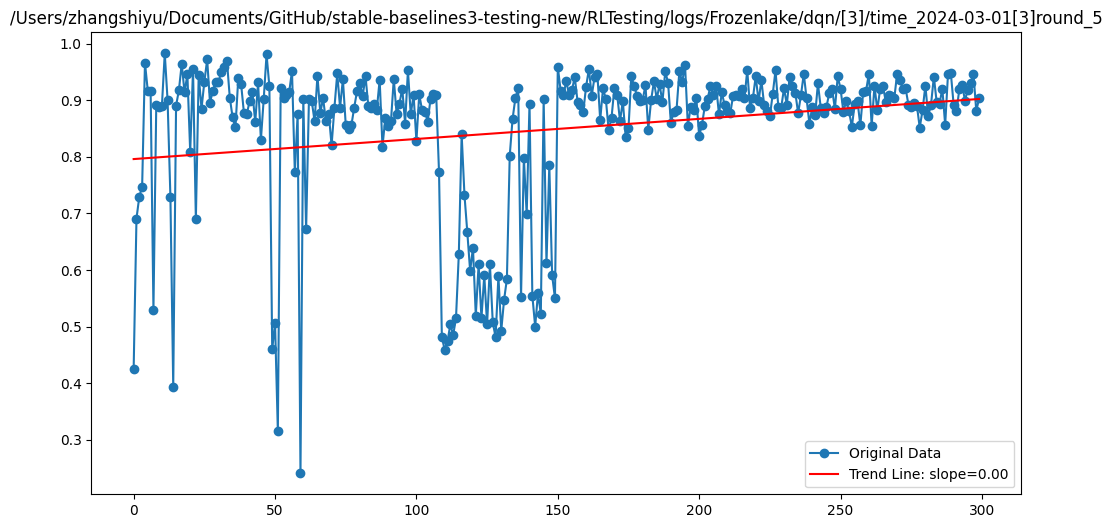

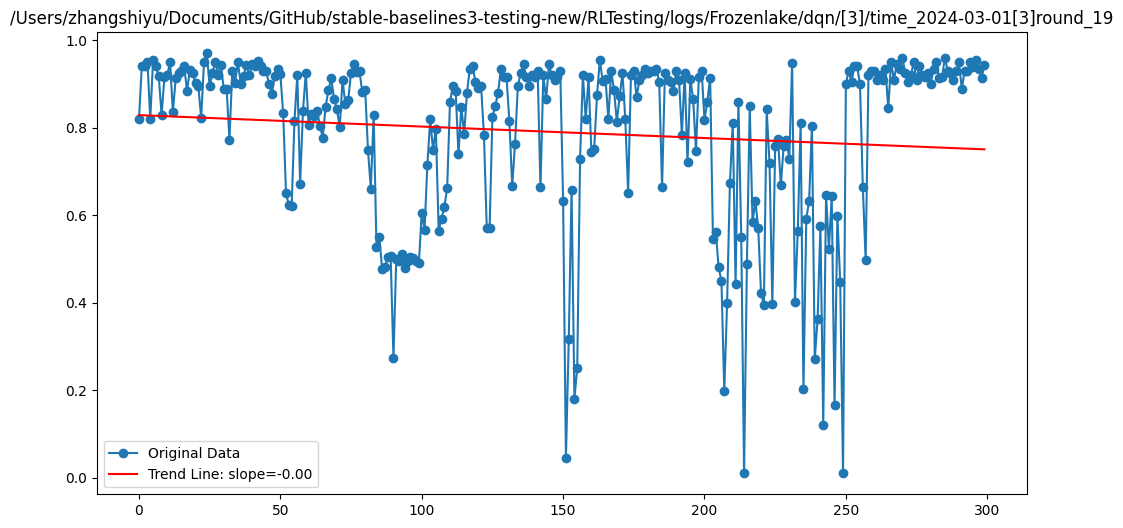

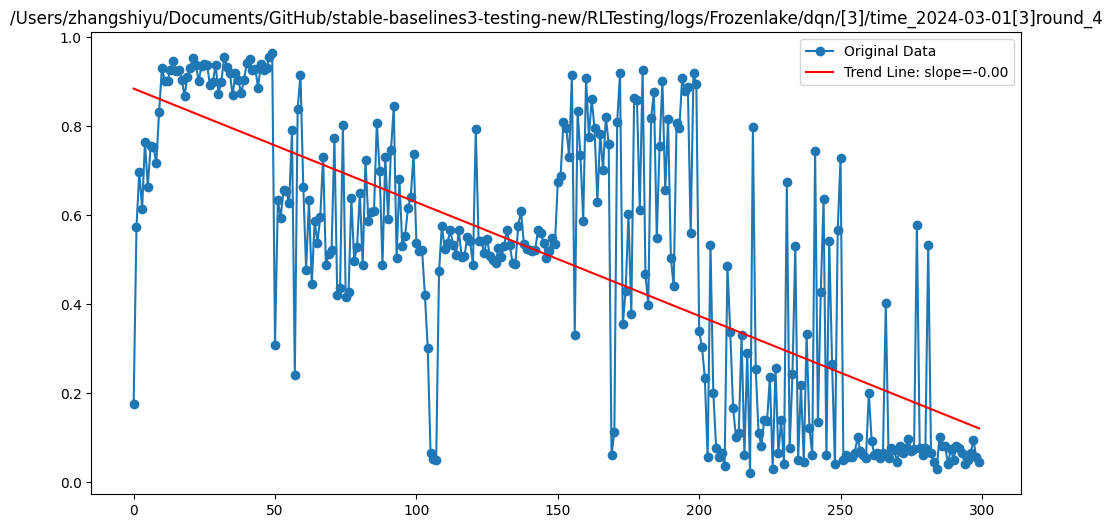

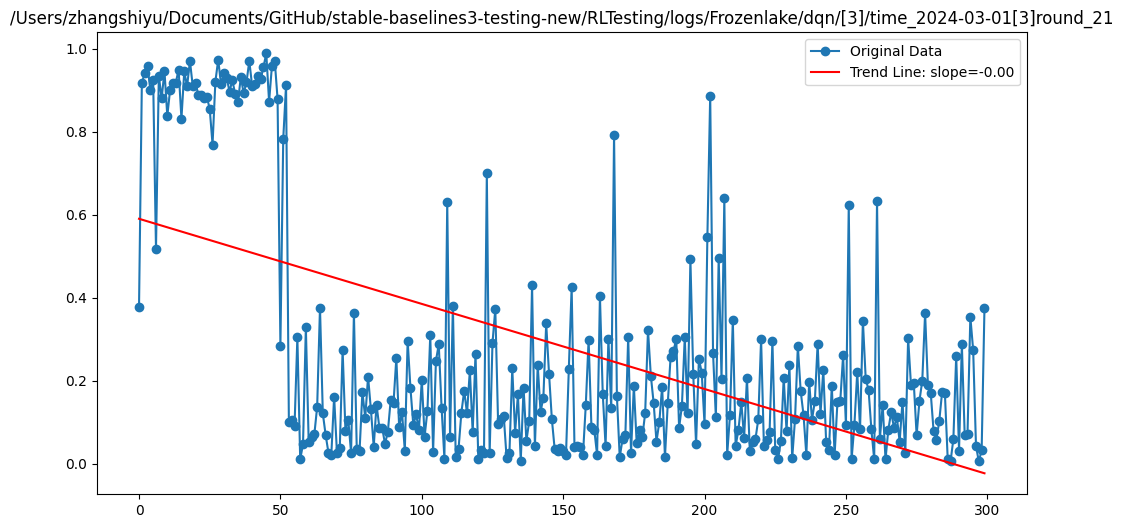

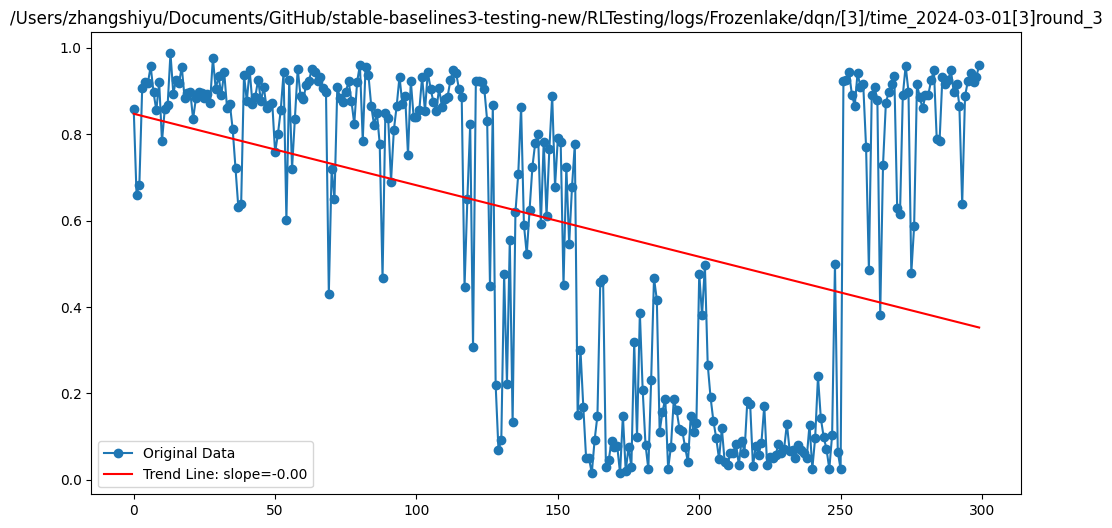

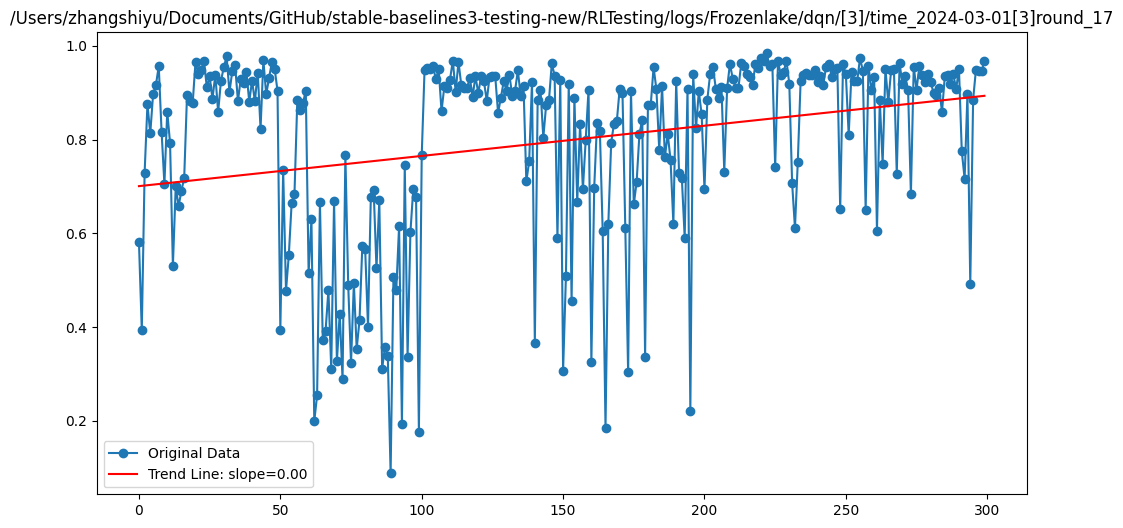

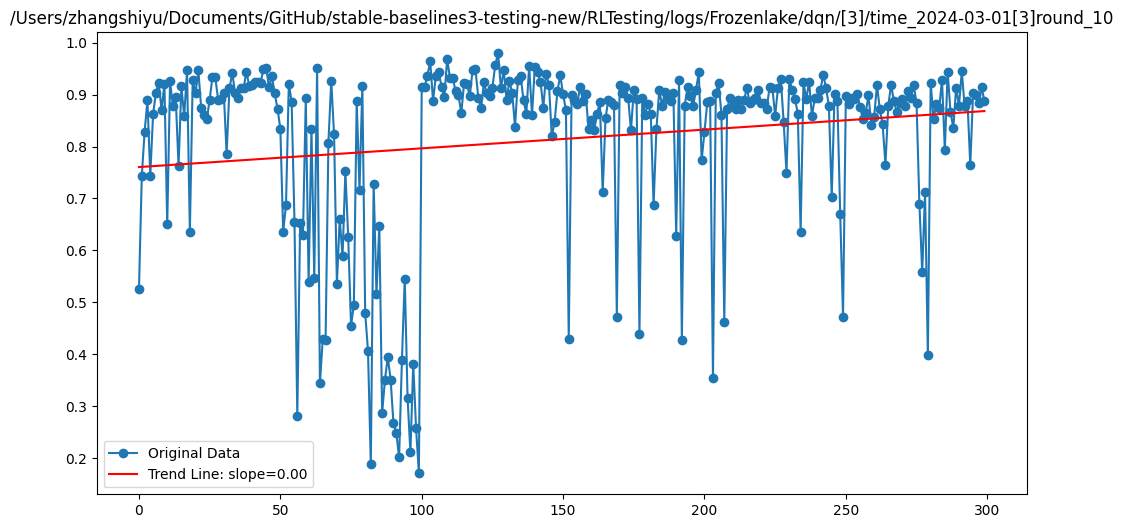

BinomTestResult(k=17, n=25, alternative='greater', statistic=0.68, pvalue=0.05387607216835022)


In [7]:
# bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[]')), show_fig=False)
# bin_test_mountaincar(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Mountaincar', 'a2c', '[]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[3]')), show_fig=True)